# Introduction
In this project, we will be analyzing video game sales data for Ice, an online store.  The data set shows video games released from 1980 to 2016.  In addition to sales broken down by region, the data shows gaming platforms, ESRB datings, user scores, and critic scores.

We will begin with a preliminary data review, followed by data preprocessing.  Moving on to exploratory data analysis, we will examine the number of game releases and total sales over time.  We will examine trends for various gaming platforms and the life-cycle of a platform.  We will identify the most profitable platforms in recent years and focus further analysis on those platforms.

We will examine the effect that game reviews, platform, genre on sales, and we will look at regional differences in the video game market.  Finally, we will perform statistical hypothesis testing to determine the relationship bewteen platform and user rating, and genre and user rating.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
from scipy.stats import levene
import warnings

warnings.filterwarnings('ignore')

try:
    df = pd.read_csv('games.csv')
except:
    df = pd.read_csv('/datasets/games.csv')

# Preliminary data review
In this section, we will take an initial look at the data to identify preprocessing requirements, including data type conversion and missing values.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
mis_values = df.isnull().sum().to_frame('missing_values')
mis_values['%'] = round(df.isnull().sum()/len(df),3)
mis_values.sort_values(by='%', ascending=False)

,missing_values,%
Critic_Score,8578,0.513
Rating,6766,0.405
User_Score,6701,0.401
Year_of_Release,269,0.016
Name,2,0.000
Platform,0,0.000
Genre,2,0.000
NA_sales,0,0.000
EU_sales,0,0.000
JP_sales,0,0.000


## Conclusion

- Column names will be converted to lowercase.
- <code>year_of_release</code> will be converted to <code>int</code>.
- Missing values
    - <code>name</code>: 2 missing
    - <code>year_of_release</code>: 269 missing
    - <code>genre</code>: 2 missing
    - <code>critic_score</code>: 8,578 missing
    - <code>user_score</code>: 6,701 missing
    - <code>rating</code>: 6,766 missing
- Additional checks needed
    - Consistency in naming: name, platform, genre, rating

# Preprocessing

## Convert column names to lowercase

In [5]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

## Total sales
Calculate the total sales (the sum of sales in all regions) for each game and put these values in a separate column.

In [6]:
df.insert(8, 'total_sales', df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1))
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,82.54,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,32.77,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,31.38,NaN,NaN,NaN


## name

In [7]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,2.39,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,0.03,NaN,NaN,NaN


In our preliminary data review, we found 2 missing values for the <code>name</code> and <code>genre</code> fields.  Here, we see that the missing values belong to the same 2 rows, and these rows are missing other fields as well.  We will drop them from the dataframe.

In [8]:
df.drop(df[df['name'].isna()].index, inplace=True)

## platform

In [9]:
df['platform'].value_counts().sort_index()

2600     133
3DO        3
3DS      520
DC        52
DS      2151
GB        98
GBA      822
GC       556
GEN       27
GG         1
N64      319
NES       98
NG        12
PC       974
PCFX       1
PS      1197
PS2     2161
PS3     1331
PS4      392
PSP     1209
PSV      430
SAT      173
SCD        6
SNES     239
TG16       2
WS         6
Wii     1320
WiiU     147
X360    1262
XB       824
XOne     247
Name: platform, dtype: int64

There do not appear to be any duplicates or inconsistencies in the <code>platform</code> field.

## year_of_release

In [10]:
df['year_of_release'].isna().sum()

269

In [11]:
df[df['year_of_release'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,5.24,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,3.50,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,3.06,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,3.00,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,2.53,NaN,NaN,NaN


In [12]:
df[df['name'] == 'Madden NFL 2004']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,5.24,94.0,8.5,E
1881,Madden NFL 2004,XB,2003.0,Sports,1.02,0.02,0.00,0.05,1.09,92.0,8.3,E
3889,Madden NFL 2004,GC,2003.0,Sports,0.40,0.10,0.00,0.01,0.51,94.0,7.7,E
5708,Madden NFL 2004,GBA,2003.0,Sports,0.22,0.08,0.00,0.01,0.31,70.0,6.6,E


In [13]:
df['year_of_release'] = df.groupby('name')['year_of_release'].apply(lambda x: x.fillna(x.mean()))
df[df['name'] == 'Madden NFL 2004']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,2003.0,Sports,4.26,0.26,0.01,0.71,5.24,94.0,8.5,E
1881,Madden NFL 2004,XB,2003.0,Sports,1.02,0.02,0.00,0.05,1.09,92.0,8.3,E
3889,Madden NFL 2004,GC,2003.0,Sports,0.40,0.10,0.00,0.01,0.51,94.0,7.7,E
5708,Madden NFL 2004,GBA,2003.0,Sports,0.22,0.08,0.00,0.01,0.31,70.0,6.6,E


In [14]:
df['year_of_release'].isna().sum()

146

Initially, there were 269 missing values for <code>year_of_release</code>.  In some cases, the data set did have a <code>year_of_release</code> for the the same game on other platforms.  Assuming that games are released on different platforms in the same year, we were able to fill in some of the missing values.  (In later sections, we will employ a similar process to fill other missing values.)

Unfortunately, we were left with 146 missing values for <code>year_of_release</code>.  There is no intuitive way to fill these missing values, and since the proportion of missing values is small (<2%), we will simply delete them.

In [15]:
df.drop(df[df['year_of_release'].isna()].index, inplace=True)
df['year_of_release'].isna().sum()

0

Finally, we will convert <code>year_of_release</code> to <code>int<code>.

In [16]:
df['year_of_release'] = df['year_of_release'].fillna(0).astype(int)

## genre
2 missing values handled above

In [17]:
df['genre'].value_counts()

Action          3342
Sports          2333
Misc            1735
Role-Playing    1484
Shooter         1311
Adventure       1294
Racing          1236
Platform         879
Simulation       860
Fighting         842
Strategy         678
Puzzle           573
Name: genre, dtype: int64

There are no obvious duplications or inconsistencies in the <code>genre</code> field.

## critic_score

In [18]:
df['critic_score'].isna().sum()

8492

In [19]:
df[df['critic_score'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,31.38,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,30.26,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,28.31,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,24.67,NaN,NaN,NaN


In [20]:
df['critic_score'] = df.groupby('name')['critic_score'].apply(lambda x: x.fillna(x.mean()))

In [21]:
df['critic_score'].isna().sum()

7532

We were able to fill 961 values for <code>critic_score</code> using the method described above for <code>year_of_release</code>.  We are still missing <code>critic_score</code> for almost half of the records in the data set.  There does not appear to be a reliable way to fill in these missing values, and filling in such a large proportion of the data set with estimates would probably lead to erroneous conclusions.  We will leave the records in the data set, and when necessary, we will filter out records with missing <code>critic_score</code>s.

In [22]:
# Replace NaN values with -5 and convert to float
df['critic_score'] = df['critic_score'].replace(np.NaN, -5)
df['critic_score'] = df['critic_score'].astype('int')

There is some consolation for the large number of missing values.  Though not shown here, analysis shows that records with missing <code>critic_score</code>s tend to be for older games (mean <code>year_of_release</code> 1983 for games with missing scores, vs. 1993 for others) and lower-revenue games (0.38 for games with missing scores, vs. 0.66 for others).

## user_score

In [23]:
df[df['user_score'] == 'tbd'].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,6.70,42,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,3.97,61,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,2.81,-5,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,2.42,71,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,2.24,-5,tbd,E


In [24]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = np.NaN

"tbd" probably stands for "to be determined."  These are missing values, so we converted them to <code>NaN</code>, like other missing values.

In [25]:
df['user_score'].isna().sum()

9027

In [26]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='raise')

In [27]:
df['user_score'] = df.groupby('name')['user_score'].apply(lambda x: x.fillna(x.mean()))

In [28]:
df['user_score'].isna().sum()

7928

We used the same name/different platform method to fill about 1,000 of the missing values, as we have done for other fields.  We were left with 7,928 missing values.  Once again, we will replace the <code>NaN</code> values with -5 as a dummy numeric value.

In [29]:
df['user_score'] = df['user_score'].replace(np.NaN, -5)
df['user_score'] = df['user_score'].astype('float')

## rating

In [30]:
df['rating'].value_counts(dropna=False)

NaN     6699
E       3958
T       2930
M       1554
E10+    1412
EC         8
K-A        3
RP         2
AO         1
Name: rating, dtype: int64

Internet research allows us to consolidate the last 4 categories into the more common ones.

- EC = "Early Childhood" → E (Everyone)
- K-A = "Kids to Adults" → E (Everyone)
- AO = "Adults Only" → M (Mature)

RP likely means Rating Pending.  We will fill these three with the most common rating, based on the game's genre.

In [31]:
df.loc[df['rating'] == 'EC', 'rating'] = 'E'
df.loc[df['rating'] == 'K-A', 'rating'] = 'E'
df.loc[df['rating'] == 'AO', 'rating'] = 'M'

In [32]:
df[df['rating'] == 'RP']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
14270,Supreme Ruler: Cold War,PC,2011,Strategy,0.0,0.03,0.0,0.01,0.04,63,6.8,RP
16180,WRC: FIA World Rally Championship,PC,2005,Racing,0.0,0.01,0.0,0.00,0.01,65,6.1,RP


In [33]:
df[df['genre'] == 'Strategy']['rating'].value_counts()

T       162
E10+     76
E        72
M        25
RP        1
Name: rating, dtype: int64

In [34]:
df[df['genre'] == 'Racing']['rating'].value_counts()

E       581
T       169
E10+     96
M        18
RP        1
Name: rating, dtype: int64

In [35]:
df.loc[df['name'] == 'Clockwork Empires', 'rating'] = 'T'
df.loc[df['name'] == 'Supreme Ruler: Cold War', 'rating'] = 'T'
df.loc[df['name'] == 'WRC: FIA World Rally Championship', 'rating'] = 'E'

In [36]:
df['rating'] = df.groupby('name')['rating'].apply(lambda x: x.fillna(st.mode(x)[0][0]))

In [37]:
df['rating'].value_counts(dropna=False)

0       6262
E       4137
T       3060
M       1646
E10+    1462
Name: rating, dtype: int64

We have 6,262 missing ESBR ratings.  We will fill these missing values with "Unknown."

In [38]:
df['rating'] = df['rating'].fillna('Unknown')

## Data type conversion


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16567 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16567 non-null  object 
 1   platform         16567 non-null  object 
 2   year_of_release  16567 non-null  int64  
 3   genre            16567 non-null  object 
 4   na_sales         16567 non-null  float64
 5   eu_sales         16567 non-null  float64
 6   jp_sales         16567 non-null  float64
 7   other_sales      16567 non-null  float64
 8   total_sales      16567 non-null  float64
 9   critic_score     16567 non-null  int64  
 10  user_score       16567 non-null  float64
 11  rating           16567 non-null  object 
dtypes: float64(6), int64(2), object(4)
memory usage: 1.6+ MB


In the preceding sections, <code>year_of_release</code> was converted to <code>int</code>, <code>critic_score</code> was converted to <code>int</code>, and <code>user_score</code> was converted to <code>float</code>.

## Handle missing values
- Explain why you filled in the missing values as you did or why you decided to leave them blank.
- Why do you think the values are missing? Give possible reasons.
- Pay attention to the abbreviation TBD (to be determined). Specify how you intend to handle such cases.

## Conclusion
In this section we performed data preprocessing.  In particular, we

- Converted column names to lower case.
- Created a column for <code>total_sales</code> by adding sales for North America, Europe, Japan, and other regions.
- Dropped two records that were missing both <code>name</code> and <code>genre</code>.
- Filled some values for <code>year_of_release</code>, <code>critic_score</code>, and <code>user_score</code> based on games with the same <code>name</code> that were not missing those values.
- Consolidated several rarely used ESRB ratings with more common ratings based on internet research.
- Converted <code>year_of_release</code> from <code>float</code> to <code>int</code>.
- Converted <code>critic_score</code> and <code>user_score</code> to numeric types.

For several fields, even after filling with default values, we were left with a large number of missing values without a reliable way to fill them.  We filled these with a dummy numeric value (-5), which can be filteted out as needed in subsequent analysis steps.

# Exploratory data analysis
In this section, we will

- Examine trends in the number of game releases and sales.
- Examine sales trends for various platforms.
- Define a time period for subsequent analysis.
- Identify top platforms recent years.
- Look how several factors (reviews, platform, and genre) relate to sales.


## Game releases by year

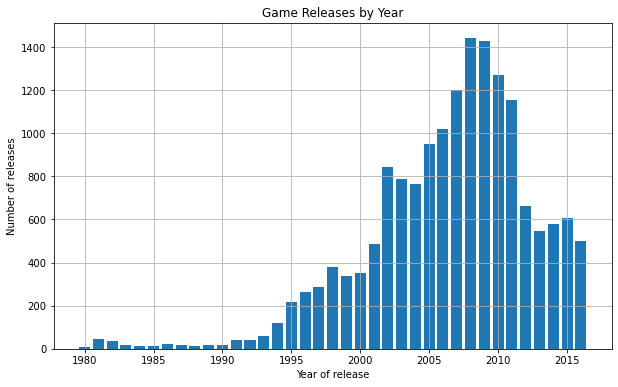

In [40]:
releases_by_year = df[df['year_of_release'] != 0].groupby('year_of_release')['name'].agg('count')
plt.figure(figsize=(10,6))
plt.bar(x=releases_by_year.index, height=releases_by_year.values)
plt.title('Game Releases by Year')
plt.xlabel("Year of release")
plt.ylabel("Number of releases")
plt.grid()
plt.show()

It appears that 2008 was the high water mark for number of video game releases.  Is this actually true, or does it reflect a problem with the data? The following link suggests that it's true: https://en.wikipedia.org/wiki/Category:Video_games_by_year.

## Sales trends

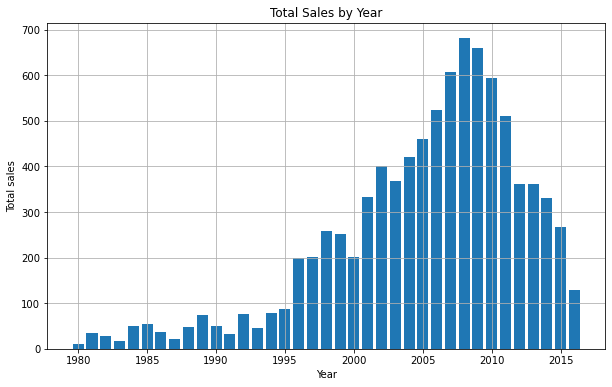

In [41]:
sales_by_year = df[df['year_of_release'] != 0].groupby('year_of_release')['total_sales'].agg('sum')
plt.figure(figsize=(10,6))
plt.bar(x=sales_by_year.index, height=sales_by_year.values)
plt.title('Total Sales by Year')
plt.xlabel("Year")
plt.ylabel("Total sales")
plt.grid()
plt.show()

We see a marked decline in both the number of game release and total sales after 2008.  This is likely due to a rise in gaming on non-dedicated mobile devices such as the iPhone (released in 2007), the iPad (released in 2010), as well as similar Android devices.  Game sales on these mobile platforms are not included in our data set.

## Sales by platform
In this section, we examine sales for various platforms.  First, we examine sales over a long period of time (2000-2015).  This will give us an idea of long-term trends and the life cycle of a gaming platform.  Next, we focus on more recent years to identify a time period, and set of gaming platforms, relavent to the current market.

### Sales (2000-15)

In [42]:
platform_sales = df.groupby('platform')['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales'].agg('sum').sort_values('total_sales', ascending=False)
top_platforms = platform_sales.head(5)
top_platforms

,na_sales,eu_sales,jp_sales,other_sales,total_sales
platform,,,,,
PS2,580.09,337.05,137.74,192.28,1247.16
X360,599.15,269.79,12.33,85.34,966.61
PS3,391.60,328.97,79.52,135.10,935.19
Wii,494.01,261.48,69.05,78.77,903.31
DS,381.38,188.72,175.02,59.16,804.28


In [43]:
platform_df = df[df['platform'].isin(top_platforms.index)].pivot_table(index='year_of_release',
                                                                       columns='platform',
                                                                       values='total_sales',
                                                                       aggfunc='sum')
platform_df.fillna(0).tail(17)

platform,DS,PS2,PS3,Wii,X360
year_of_release,,,,,
2000,0.00,39.17,0.00,0.00,0.00
2001,0.00,166.43,0.48,0.00,0.00
2002,0.00,208.36,0.00,0.00,0.00
2003,0.00,194.00,0.00,0.00,0.00
2004,17.27,211.81,0.00,0.00,0.00
2005,130.14,160.91,0.19,0.00,9.22
2006,119.81,103.99,20.96,140.19,51.79
2007,147.23,76.10,73.19,153.41,95.41
2008,145.36,53.90,118.79,177.68,136.07


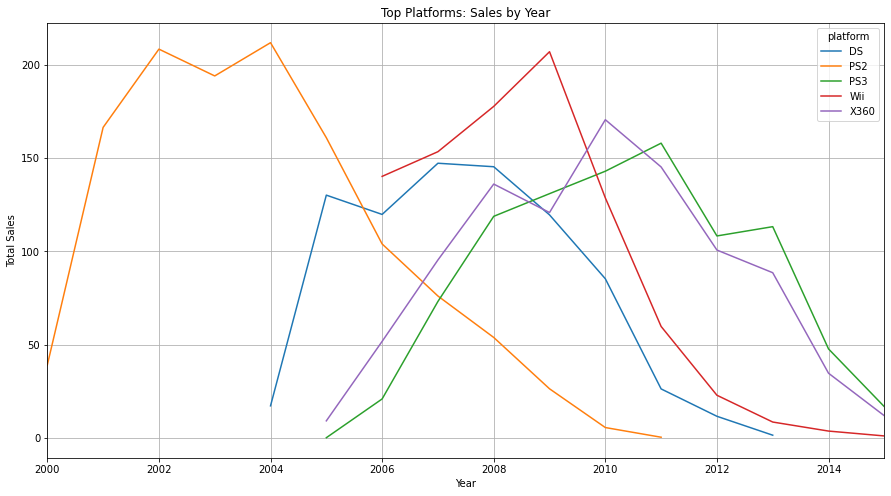

In [44]:
platform_df.reset_index().plot(x='year_of_release', figsize=(15,8), grid=True)
plt.xlim(2000, 2015)
plt.title('Top Platforms: Sales by Year')
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.show()

Over this long period (2000-15) we observe the rise and fall of several gaming platforms.  During this period, the PS2 had the greatest total sales.  We can get an idea of the life cycle of a platform.

- PS2: 11 years (2000-11)
- DS: 9 years (2004-13)
- X360: 10 years 2005-2015)
- Wii 8 years (2006-14)
- PS3: 10 years (2005-15)

## Recent Sales (2010-2015)
In this section, we focus on sales in more recent years.  As we have seen, this is a period of declining sales overall, but this period does see a rise in two newer platforms, XOne and PS4.

In [45]:
recent_platform_sales = df.query('year_of_release > 2010').groupby('platform')['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales'].agg('sum').sort_values('total_sales', ascending=False)
recent_top_platforms = recent_platform_sales.head(6)
recent_top_platforms

,na_sales,eu_sales,jp_sales,other_sales,total_sales
platform,,,,,
PS3,168.96,164.15,49.40,65.18,447.69
X360,228.18,117.87,3.36,33.34,382.75
PS4,108.74,141.09,15.96,48.35,314.14
3DS,82.83,61.46,100.62,13.30,258.21
XOne,93.12,51.59,0.34,14.27,159.32
PC,30.08,57.38,0.00,11.21,98.67


In [46]:
recent_platform_df = df[df['platform'].isin(recent_top_platforms.index)].pivot_table(index='year_of_release',
                                                                 columns='platform',
                                                                 values='total_sales',
                                                                 aggfunc='sum')

recent_platform_df.fillna(0).tail()

platform,3DS,PC,PS3,PS4,X360,XOne
year_of_release,,,,,,
2012,51.76,23.45,108.28,0.00,100.72,0.00
2013,56.57,13.01,113.25,25.99,88.58,18.96
2014,43.76,13.28,47.76,100.00,34.74,54.07
2015,27.78,8.52,16.82,118.90,11.96,60.14
2016,15.14,5.25,3.60,69.25,1.52,26.15


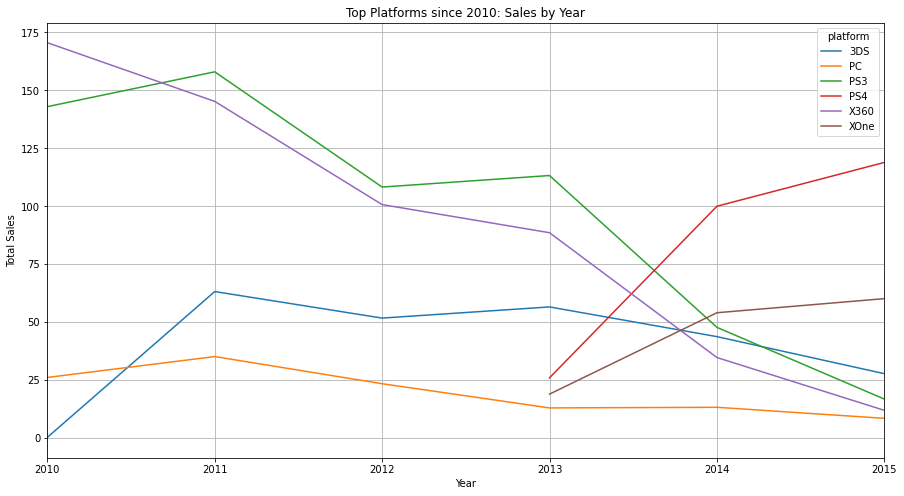

In [47]:
recent_platform_df.reset_index().plot(x='year_of_release', figsize=(15,8), grid=True)
plt.xlim()
plt.xlim(2010, 2015)
plt.title('Top Platforms since 2010: Sales by Year')
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.show()

## Define period for analysis
The market changed in 2013, with the introduction of XOne and PS4.  Since then, we have seen growth of these new platforms and declines older ones.  The data for 2016 appears to be incomplete, as it shows a sudden decilne in sales of these two new platforms.  In order to capture recent market trends, and to avoid erroneous conclusions based on incomplete data from 2016, we will focus on 2013-2015.

In [48]:
# Filter original dataframe for top selling platforms in recent years
df_sel = df[df['platform'].isin(recent_top_platforms.index)]

# Further limit to 2013-2015
df_sel = df_sel.query('2013 <= year_of_release <= 2015')

## Profitable platforms
As of 2015, there are 6 platforms that can be deemed "active."  Two are growing, and the other 4 are declining.

Growing:

- PS4:  Released in 2013.  Current sales leader.
- XOne:  Released in 2013.

Declining:

- 3DS
- PS3
- X360
- PC:  Declining very slowly.

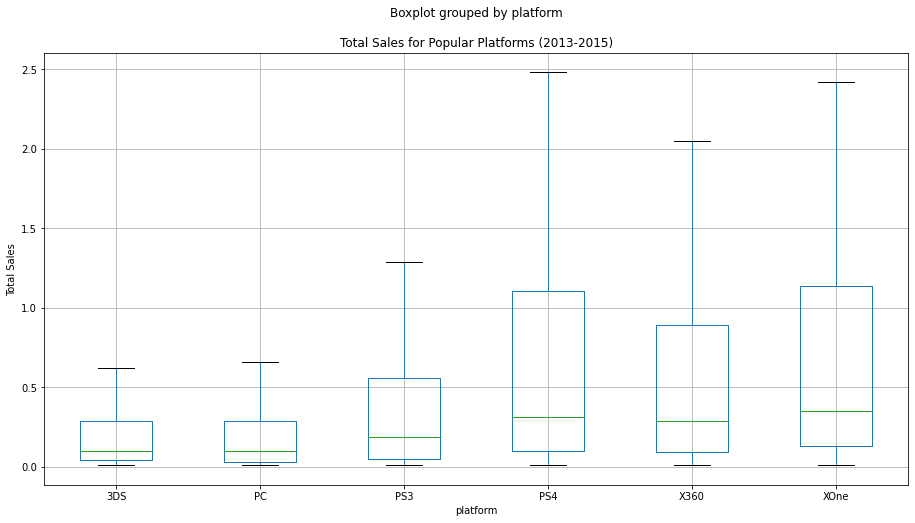

In [49]:
ax = df_sel.boxplot(column='total_sales', by='platform', figsize=(15,8), showfliers=False)
ax.set_ylabel('Total Sales')
ax.set_title('Total Sales for Popular Platforms (2013-2015)');

In [50]:
df_sel.groupby('platform')['total_sales'].agg(['mean', 'median']).sort_values(by='mean', ascending=False)

,mean,median
platform,,
PS4,1.074079,0.31
XOne,0.832312,0.35
X360,0.781965,0.29
PS3,0.579251,0.19
3DS,0.498482,0.10
PC,0.252246,0.10


The boxplots show the distribution of sales broken down by platform.  The growth platforms (PS4 and XOne) exhibit the highest mean and median sales.  The most noteworthy finding here is that sales are driven by blockbuster titles. For each plot, the mean is much greater than the median, indicating that a relatively small number of blockbuster games are skewing skew the distribution toward higher total sales.

## Effect of reviews
In this section we examine the relationship between game reviews and sales for the current leading platform, the PS4.

### Critic score

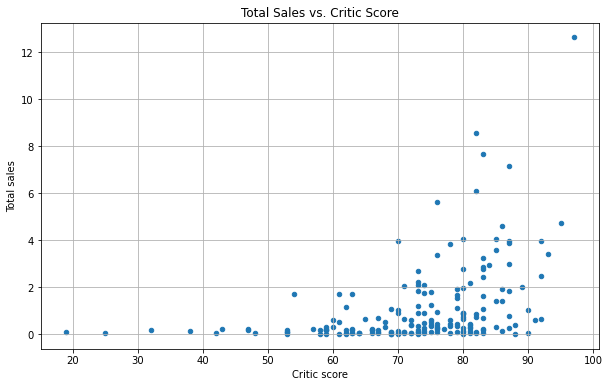

In [51]:
df_review = df_sel.query('platform == "PS4" & critic_score != -5')
df_review.plot(kind='scatter', x='critic_score', y='total_sales', figsize=(10,6))
plt.title('Total Sales vs. Critic Score')
plt.xlabel('Critic score')
plt.ylabel('Total sales')
plt.grid()
plt.show()

In [52]:
df_review['critic_score'].corr(df_review['total_sales'])

0.4063256431988396

Although not readily apparent from the graph, there are no zero or missing values for either <code>total_sales</code> or <code>critic_score</code>.  We could say that a high critic score is necessary, but not sufficient, for high sales.  In other words, there are no poorly-reviewed games with high sales, but there are well-reviewed games with low sales.  Overall, there is little correlation between the two variables, and this is reflected by the correlation coefficient of 0.4.

### User score

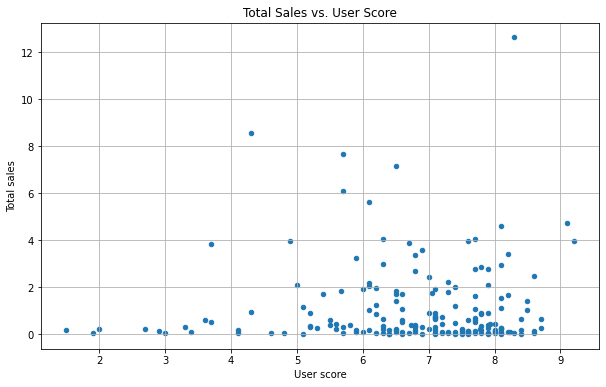

In [53]:
df_review = df_sel.query('platform == "PS4" & user_score != -5')
df_review.plot(kind='scatter', x='user_score', y='total_sales', figsize=(10,6))
plt.title('Total Sales vs. User Score')
plt.xlabel('User score')
plt.ylabel('Total sales')
plt.grid()
plt.show()

In [54]:
df_review['user_score'].corr(df_review['total_sales'])

0.0227178477576005

Here we see that users may be even more discriminating than critics, in the sense that there are several games that sold well yet had poor user scores.  Overall, there is almost no correlation bewteen <code>user_score</code> and <code>total_sales</code>, and this is confirmed by the correlation coefficient of 0.02.

## Effect of platform

In [55]:
df_platform = df_sel.pivot_table(index='name', columns='platform', values='total_sales')
df_platform = df_platform.fillna(0)
df_platform['total'] = df_platform.apply(lambda x: sum(x), axis=1)
df_platform = df_platform.sort_values(by='total', ascending=False).head(5)
#df_platform = df_platform.drop(columns=['3DS'])
df_platform

platform,3DS,PC,PS3,PS4,X360,XOne,total
name,,,,,,,
Grand Theft Auto V,0.0,1.17,21.05,12.62,16.27,5.47,56.58
Call of Duty: Ghosts,0.0,0.69,9.36,3.83,10.24,2.92,27.04
Call of Duty: Black Ops 3,0.0,0.26,1.69,14.63,1.70,7.39,25.67
Call of Duty: Advanced Warfare,0.0,0.41,4.36,7.66,4.28,5.26,21.97
Minecraft,0.0,0.00,5.27,4.32,9.18,2.76,21.53


These are some of the "blockbuster" games mentioned earlier.  The highest selling game (_Grand Theft Auto V_) is not the leader on the top platform (PS4) and has higher sales on other platforms (PS3 and X360).  Another top seller (_Call of Duty: Black Ops 3_) sells very well on PS4 but not as well on X360.  The 3DS, while in the list of the top 6 platforms, does not support any of these blockbusters, which require more hardware power than is available on a portable device.

In [56]:
df_platform = df_sel.pivot_table(index='name', columns='platform', values='total_sales')
df_platform = df_platform.dropna((0))
df_platform['total'] = df_platform.apply(lambda x: sum(x), axis=1)
df_platform = df_platform.sort_values(by='total', ascending=False).head(5)
df_platform

platform,3DS,PC,PS3,PS4,X360,XOne,total
name,,,,,,,
FIFA 15,0.46,0.29,4.28,6.08,2.92,2.18,16.21
FIFA 14,0.23,0.40,6.46,3.01,4.22,1.16,15.48
LEGO Marvel Super Heroes,0.89,0.17,1.83,1.62,2.22,1.05,7.78
The LEGO Movie Videogame,0.69,0.06,0.93,0.67,1.27,0.53,4.15
LEGO Jurassic World,0.62,0.04,0.85,0.90,0.87,0.66,3.94


There are the top sellers that are available on all 6 platforms (i.e., including the DS).  Again, the leading platform (PS4) is not the leading platform for every game.  For instance, some of the Lego games have higher sales on the X360 and the older PS3 than on the market-leading PS4.

## Genre

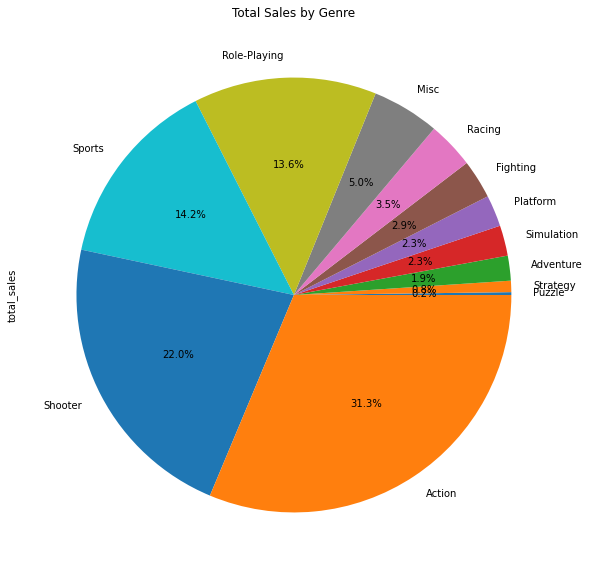

In [57]:
by_genre = pd.DataFrame(df_sel.groupby('genre')['total_sales'].agg('sum')).sort_values(by='total_sales')
title = 'Total Sales by Genre'
by_genre.plot(y='total_sales', kind='pie', legend=False, autopct='%1.1f%%', figsize=(10,10), title=title);

The Action and Shooter genres are the top genres, accounting for more than 50% of the market in recent years.  One explanation is that these genres take fuller advantages of technological advancements in graphics technology than some of the less-popular genres, such as Platform, Simulation, Strategy, and Puzzle.

## Conclusion
In this section, we performed exploratory data analysis and made the following observations:

-  The video game market, at least as reflected in this data set, appears to be declining.  The number of new releases and total yearly sales have been declining since about 2008.  This may be due to the rise of general purpose portable devices such as the iPhone and iPad, as well as the increasing popularity of watching others play games on Youtube.
- A look at platform trends from 2000 to 2015 shows the rise and fall of several platforms.  Historically, the life cycle of a platform is about 10 years.
- The video game market changed in 2013 with the introduction of XOne and PS4.  These platforms have been growing in recent years, while others have been declining.
- While many games are released each year, most have low sales.  Sales are driven by a relatively small number of blockbuster games.
- Critic reviews exhibit low correlation with sales.  High critic reviews are necessary but not sufficient to have high sales.  User reviews show even less correlation with sales, as some games sell well despite poor user reviews.
- The leading platform (PS4) is not the leader for all games, even for blockbuster games.  The most popular games are not available on portable devices (DS3).
- The Action and Shooter genres account for slightly more than half of the market.  These genres tend to exploit technological advances in gaming platforms more than less popular genres.

# Regional user profile

## Top platforms by region

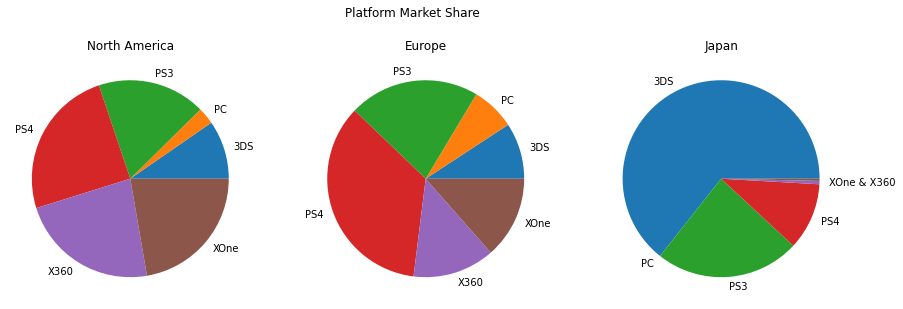

In [58]:
na_platforms = pd.DataFrame(df_sel.groupby('platform')['na_sales'].agg('sum'))
eu_platforms = pd.DataFrame(df_sel.groupby('platform')['eu_sales'].agg('sum'))
jp_platforms = pd.DataFrame(df_sel.groupby('platform')['jp_sales'].agg('sum'))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Platform Market Share')

ax1.set_title('North America')
ax1.pie(na_platforms['na_sales'], labels=na_platforms.index)

ax2.set_title('Europe')
ax2.pie(eu_platforms['eu_sales'], labels=eu_platforms.index)

ax3.set_title('Japan')
jp_labels = jp_platforms.index.tolist()[:-2]
jp_labels.append('XOne & X360')
jp_labels.append('')
ax3.pie(jp_platforms['jp_sales'], labels=jp_labels)

plt.show()

In [59]:
na_platforms = round(na_platforms/na_platforms.sum()*100, 1)
na_platforms.columns = ['NA %']
eu_platforms = round(eu_platforms/eu_platforms.sum()*100, 1)
eu_platforms.columns = ['EU %']
jp_platforms = round(jp_platforms/jp_platforms.sum()*100, 1)
jp_platforms.columns = ['JP %']
na_platforms.join(eu_platforms).join(jp_platforms)

,NA %,EU %,JP %
platform,,,
3DS,9.6,9.2,64.4
PC,2.8,7.2,0.0
PS3,17.8,21.4,23.7
PS4,24.7,35.2,11.0
X360,22.9,13.5,0.5
XOne,22.3,13.5,0.4


The market shares of various platforms are similar for North America and Europe, but there is a difference in the adoption of the newer platforms, PS4 and XOne.  North America has been friendlier to the XOne, while Europe has been faster to adopt the PS4.  PC gaming appears to retain a bit more popularity in Europe than in North America.

While North America and Europe showed similar market shares for various platforms, Japan presents a very different picture.  In Japan, the portable 3DS is dominant, and among consoles, the PS3 and PS4 dwarf the popularity of Microsoft's platforms.

## Top genres by region

In [60]:
na_rank = df_sel.groupby('genre')['na_sales'].agg('sum').sort_values(ascending=False).head(5).index
eu_rank = df_sel.groupby('genre')['eu_sales'].agg('sum').sort_values(ascending=False).head(5).index
jp_rank = df_sel.groupby('genre')['jp_sales'].agg('sum').sort_values(ascending=False).head(5).index
pd.DataFrame({'NA ranking' : na_rank, 'EU ranking' : eu_rank, 'JP ranking' : jp_rank})

,NA ranking,EU ranking,JP ranking
0,Action,Action,Role-Playing
1,Shooter,Shooter,Action
2,Sports,Sports,Fighting
3,Role-Playing,Role-Playing,Misc
4,Misc,Racing,Simulation


Just as the market shares of platform are similar for Europe and North America, so, too, are market shares of various genres.

Again, Japan is different, with Role-Playing games taking the lead and Shooter and Sports games failing to make the top 5.  The difference in the popularity of various genres may reflect cultural differences, as well as the fact that some blockbuster games are not available on the 3DS, while is so popular in Japan.

## Regional effect of ESRB rating

In [61]:
na = df_sel.groupby('rating')['na_sales'].agg('sum')[1:]
na = pd.DataFrame(round(na/na.sum()*100, 1))
eu = df_sel.groupby('rating')['eu_sales'].agg('sum')[1:]
eu = pd.DataFrame(round(eu/eu.sum()*100, 1))
jp = df_sel.groupby('rating')['jp_sales'].agg('sum')[1:]
jp = round(jp/jp.sum()*100, 1)
rating = na.join(eu).join(jp)
rating

,na_sales,eu_sales,jp_sales
rating,,,
E,20.3,23.3,23.7
E10+,13.1,11.5,9.3
M,53.1,53.0,30.7
T,13.4,12.1,36.4


Does ESRB rating affect game sales in different regions?  We have insufficient data to answer this question.  In fact, rating systems vary by country.  ESRB is used in North America, but Europe uses a system called PEGI and Japan uses a system called CERO (https://www.makeuseof.com/tag/video-game-ratings-guide-esrb-pegi/).  What we can observe is that, once again, the North American and European markets are similar, while the Japanese market is different.  In the Japanese market, games rated M (Mature) have lower sales, while games rated T (Teen) are have higher sales.

## Conclusion
In this section, we looked at platform market share, genre popularity, and ESRB ratings by region.

- Platform market share is similar in North America and Europe, but North America has shown slightly greater adoption of XOne.
- Platform market share is different in Japan, where the 3DS is relatively popular, and among consoles, the PS3 and PS4 are dominant, while the X360 and XOne have almost no market share.
- In terms of genre popularity, again, North America and Europe are similar, and Action is the most popular genre.  In Japan, role playing is the most popular genre.  The differences in genre popularity may reflect cultural differences as well as the fact that genre is somewhat related to platform, and as we've seen, platform market share is different in Japan.
- North America and Europe show similar sales percentages for various ESRB ratings.  However, comparing ESRB ratings among regions is problematic because ESRB a North American system, and Europe and Japan use different systems.

# Statistical data analysis
In this section, we perform statistical hypothesis tests two answer two questions, as stated below.

For our hypothesis tests, we will use a signifiance level (alpha) of 0.05. This is a conventional, albeit arbitrary, choice. If we were to choose a higher alpha, such as 0.1, we would increase the risk making a type I error, i.e., mistakenly concluding that there is a difference (rejecting the null hypothesis) when in fact there is no difference. On the other hand, if we were to select a lower alpha, such as 0.01, we would increase the risk of making a type II error, mistakenly concluding that is is no difference (failing to reject the null hypothesis), when in fact there is a difference.

## Are the average user ratings of the Xbox One and PC platforms are the same?

In [62]:
df_xbox_ratings = df_sel.query('platform == "XOne" & platform == platform & user_score != -5')['user_score'].values
print('Xbox One: {:.0f} user scores with mean of {:.2f} and variance of {:.2f}.'.format(len(df_xbox_ratings), df_xbox_ratings.mean(), np.var(df_xbox_ratings)))

df_pc_ratings = df_sel.query('platform == "PC" & platform == platform & user_score != -5')['user_score'].values
print('PC: {:.0f} user scores with mean of {:.2f} and variance of {:.2f}.'.format(len(df_pc_ratings), df_pc_ratings.mean(), np.var(df_pc_ratings)))

Xbox One: 132 user scores with mean of 6.55 and variance of 1.70.
PC: 115 user scores with mean of 6.25 and variance of 3.03.


The Xbox One has higher average user scores, but could this difference be due to chance?  To answer this question, we will construct a hypothesis test.
- **H<sub>0</sub>**: The average user scores of the Xbox One and PC are equal.
- **H<sub>1</sub>**: The average user scores of the Xbox One and PC are not equal.

In [63]:
results = levene(df_xbox_ratings, df_pc_ratings)
if results.pvalue < 0.05:
    print('Levene test: user score distributions do NOT have equal variance. (p={:.2e})'.format(results.pvalue))
else:
    print('Levene test: user score distributions DO have equal variance. (p={:.2e})'.format(results.pvalue))

Levene test: user score distributions do NOT have equal variance. (p=2.19e-03)


In [64]:
alpha = 0.05
results = st.ttest_ind(df_xbox_ratings, df_pc_ratings, equal_var=False)

print('p-value: {:.2e}'.format(results.pvalue))

if results.pvalue < alpha:
    print("We reject the null hypothesis.")
else:
    print("We can't reject the null hypothesis.") 

p-value: 1.39e-01
We can't reject the null hypothesis.


Assuming that the null hypothesis (that the average user scores for Xbox One and PC are equal) is true, there is a 14%  of observing a difference in average user scores of 0.3 (6.55 - 6.25).  Therefore, we can't reject the null hypothesis, and we conclude that there is no statistical difference in average user scores for the two platforms.

## Are the average user ratings for the Action and Sports genres different?

In [65]:
df_action_ratings = df_sel.query('genre == "Action" & user_score != -5')['user_score'].values
print('Action genre: {:.0f} user scores with mean of {:.2f} and variance of {:.2f}.'.format(len(df_action_ratings), df_action_ratings.mean(), np.var(df_action_ratings)))

df_sports_ratings = df_sel.query('genre == "Sports" & user_score != -5')['user_score'].values
print('Sports genre: {:.0f} user scores with mean of {:.2f} and variance of {:.2f}.'.format(len(df_sports_ratings), df_sports_ratings.mean(), np.var(df_sports_ratings)))

Action genre: 291 user scores with mean of 6.87 and variance of 1.63.
Sports genre: 121 user scores with mean of 5.10 and variance of 2.64.


The Action genre higher average user scores, but could this difference be due to chance?  To answer this question, we will construct a hypothesis test.
- **H<sub>0</sub>**: The average user scores for the Action and Sports genres are equal.
- **H<sub>1</sub>**: The average user scores of the Action and Sports genres are not equal.

In [66]:
results = levene(df_action_ratings, df_sports_ratings)
if results.pvalue < 0.05:
    print('Levene test: user score distributions do NOT have equal variance. (p={:.2e})'.format(results.pvalue))
else:
    print('Levene test: user score distributions DO have equal variance. (p={:.2e})'.format(results.pvalue))

Levene test: user score distributions do NOT have equal variance. (p=6.27e-05)


In [67]:
alpha = 0.05
results = st.ttest_ind(df_action_ratings, df_sports_ratings, equal_var=False)

print('p-value: {:.2e}'.format(results.pvalue))

if results.pvalue < alpha:
    print("We reject the null hypothesis.")
else:
    print("We can't reject the null hypothesis.") 

p-value: 6.60e-21
We reject the null hypothesis.


Assuming that the null hypothesis (that the average rates for the Action an Sports genres are equal) is true, there is essentially zero probability of observing a difference of 1.77 (6.87 - 5.1).  Therefore, we reject the null hypothesis and conclude that there is a statistically significant difference in average user ratings for the two genres.

## Conclusion
In this section, we performed hypothesis tests to answer two questions:

1. Are the average user ratings of the Xbox One and PC platforms are the same?
    - We failed to find a statistically significant difference in the average user ratings for these two platforms.
2. Are the average user ratings for the Action and Sports genres different?
    - We did find a statistically significant difference in the average ratings for these two genres.

# Conclusion
In this project, analyzed video game sales data for Ice, an online store.

- During our preliminary data review, we identified missing values and other preprocessing needs.
- In data preprocessing, we carried out the preprocessing requirements as identified.  We added a column for <code>total_sales</code>, changed the data type for <code>year_of_release</code>, and filled in default values where possible.  However, our data set had many missing values that could not be filled by anything other than a dummy value.
- In the exploratory data analysis phase, we made several observations:
    - The video game market, as reflected in this data set, appears to be declining.  This is likely due to the introduction of smart phones and tablets.
    - Current conditions in the market were established in 2013, with the introduction of XOne and PS4.  We found that data for 2016 was incomplete, so we focused subsequent analysis on three years: 2013-2015.
    - Total video game sales are driven by a relatively small number of blockbuster releases.
    - Critic and user reviews exhibit poor correlation with sales.
    - The PS4 is the leading platform, but it is not the leading platform for all games.  The DS3 is a popular mobile platform that doesn't support graphics-intensive blockbuster games.
    - The Action and Shooter genres account for slightly more than half of the market. These genres tend to exploit technological advances in gaming platforms more than less popular genres.
- Next, we developed a regional user profile for the video game market.
    - North America and Europe exhibit similar characteristics in terms of platform market share and genre popularity.
    - In Japan, the DS3 platform is very popular, and Role Playing is a more popular genre.
    - North America and Europe exhibit similar sales breakdown by ESRB rating, but ESRB may be inappropriate for comparison between regions because Europe and Japan use different rating systems.
- Finally, we performed statistical hypothesis testing.
    - We did not find a statistically significant difference in average user rating between the Xbox One and PC platforms.
    - We did find a statistically significant difference in average user rating between the Action and Sports genres.
